Set up the running environment and file path for the following data: NSD, NSD_beta, exp_design files.

In [11]:
from collections import defaultdict
import sys
import os
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
import statsmodels.stats.multitest as ssm
import nibabel as nib
import cortex
import cortex.polyutils
from neuromaps import transforms
np.random.seed(1234)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nilearn import surface
import shutil
import pathlib

'''
'''
os.chdir(os.getcwd())
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
method = "ViLT"
fsa = "fsaverage5"
subj = "subj01"
hemi = ["lh", "rh"]
cap_lenght = 's'
nsd_root = "/data/public/wbc/NSDdataset/"
beta_root = "/data/public/wbc/vol2surf"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
mask_root = nsd_root + "nsddata/ppdata/"
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
output_dir = "/data/public/wbc/data_analysis/nsddata_voxel_analysis/things/ViLT/output"
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1  # 减1 变为0-base

basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

Load the embedding data generated in the previous step. Distribute data to each participant based on experimental design files.

In [12]:
catembedding = np.load('/data/public/wbc/data_analysis/nsddata_voxel_analysis/things/ViLT/ViLT_embdding_{}.npy'.format(cap_lenght))  # (73000,code_lenght)
catembedding = catembedding.reshape(73000,-1)
catembedding_data = {}
for k, s in enumerate(subject_idx):  # subject_idx:8 x 10000, Record the STIM numbers seen by each participant
    embedding_list = []
    for id in tqdm(s):  
        embedding_list.append(catembedding[id-1,:]) 
    catembedding_data[k] = np.array(embedding_list)  # Result of loop end：key:0~7; catembedding_data[i]:10000x133, embedding the one hot encoding defined by the image number seen by each participant_ List

catembedding_data = catembedding_data[int(subj[-1])-1]
del catembedding
gc.collect()

8it [00:00, 27.86it/s]


29

Load beta data. Because the data is quite large, it is necessary to proactively release memory in a timely manner.

In [3]:
beta_data_path = os.path.join(beta_root, subj, "fsaverage") 
lh_beta_file_name = "lh" + '_{}_betas.h5'.format(fsa)
beta_file = os.path.join(beta_data_path, lh_beta_file_name)
hemi_file = h5py.File(beta_file, 'r')
hemi_beta_data = hemi_file['betas']
lh_arr = np.array(hemi_beta_data)
del hemi_beta_data
gc.collect()

rh_beta_file_name = "rh" + '_{}_betas.h5'.format(fsa)
beta_file = os.path.join(beta_data_path, rh_beta_file_name)
hemi_file = h5py.File(beta_file, 'r')
hemi_beta_data = hemi_file['betas']
rh_arr = np.array(hemi_beta_data)
del hemi_beta_data
gc.collect()
arr2 = np.concatenate((lh_arr, rh_arr), axis=1).transpose(0,2,1)
voxel_data = arr2.reshape(-1,arr2.shape[2])  # (27750,num of vertex)
nan_num = np.count_nonzero(voxel_data != voxel_data)
voxel_data = np.nan_to_num(voxel_data)
del arr2
gc.collect()

0

Divide the training and testing sets to obtain trials with corresponding voxel responses

In [4]:

idx_list = []
def data_split(stim, voxel, ordering, imagewise=True):
    data_size, nv = voxel.shape  # data_size=27750, nv = 20484, voxel:(27750,20484) 
    print ("data_size = %d and total number of voxels = %d" % (data_size, nv))
    ordering_data = ordering[:data_size]  # Take out the first 27750 columns (actual experimental data)
    shared_mask = ordering_data<1000  # the first 1000 indices are the shared indices。

    val_voxel_st = voxel[shared_mask]  # Filter out values with a subscript of true to form a new array (voxel)
    val_stim_st  = stim[ordering_data[shared_mask]]  # Filter out values with a subscript of true to form a new array (stim)

    idx = np.unique(ordering_data)  # Remove ordering_ Repeated STIM numbers in data and arranged in ascending order )
    idx_list = [ordering_data==i for i in idx]  # （9841，27750） true or false. idx_list represents each stem in the ordering_ The position in the data, where true indicates that it appears at that position
    voxel_avg_data = np.zeros(shape=(len(idx), nv), dtype=np.float32)  # (9841,20484)
    for i,m in enumerate(idx_list):
        voxel_avg_data[i] = np.mean(voxel[m], axis=0)  # Obtained the average beta value of each image (repeated 3 times) on each vertex, and corresponded the image to the beta value
    shared_mask_mt = idx<1000

    val_voxel_mt = voxel_avg_data[shared_mask_mt]  # （9841,1）
    val_stim_mt  = stim[idx][shared_mask_mt]  # （9841,133）
    
    if imagewise:
        trn_voxel = voxel_avg_data[~shared_mask_mt]
        trn_stim  = stim[idx][~shared_mask_mt] 
        return trn_stim, trn_voxel, val_stim_st, val_voxel_st, val_stim_mt, val_voxel_mt
    else:
        trn_voxel = voxel[~shared_mask]
        trn_stim = stim[ordering_data[~shared_mask]]
        return trn_stim, trn_voxel, val_stim_st, val_voxel_st, val_stim_mt, val_voxel_mt

trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(catembedding_data, voxel_data, ordering, imagewise=False) 
print("trn_stim_data.shape=", trn_stim_data.shape)  # (24980, 133)  37*750=27750; 24980+2770=27750
print("trn_voxel_data.shape=", trn_voxel_data.shape)  # (24980, 20484)
print("val_stim_single_trial_data.shape=", val_stim_single_trial_data.shape)   
print("val_voxel_single_trial_data.shape=", val_voxel_single_trial_data.shape)  
print("val_stim_multi_trial_data.shape=", val_stim_multi_trial_data.shape)  
print("val_voxel_multi_trial_data.shape=", val_voxel_multi_trial_data.shape)  

data_size = 27750 and total number of voxels = 20484
trn_stim_data.shape= (24980, 768)
trn_voxel_data.shape= (24980, 20484)
val_stim_single_trial_data.shape= (2770, 768)
val_voxel_single_trial_data.shape= (2770, 20484)
val_stim_multi_trial_data.shape= (982, 768)
val_voxel_multi_trial_data.shape= (982, 20484)


Set up a ridge regression model and use ten fold cross validation

In [5]:
from sklearn.model_selection import KFold
alphas = np.logspace(1, 20, 20)
n_samples_train = trn_stim_data.shape[0]
cv = KFold(n_splits=10, shuffle=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import *

kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas, cv=cv, kernel="linear", 
    # force_cpu=True,
    # Y_in_cpu=True,
    solver_params=dict(
                        n_targets_batch=16, 
                        n_alphas_batch=1,
                        n_targets_batch_refit=10
                    )
                    )

Train and validate the model. If there is a pre trained model, load it directly.

In [6]:

from sklearn.preprocessing import StandardScaler

scaler1= StandardScaler(with_mean=True, with_std=False)
trn_stim_data = scaler1.fit_transform(trn_stim_data)
trn_voxel_data = scaler1.fit_transform(trn_voxel_data)
trn_stim_data = trn_stim_data.astype("float32")
trn_voxel_data = trn_voxel_data.astype("float32")
val_stim_single_trial_data = val_stim_single_trial_data.astype("float32")
val_voxel_single_trial_data = val_voxel_single_trial_data.astype("float32")

backend = set_backend("torch_cuda", on_error="warn")

model_path = os.path.join(output_dir, subj)
model_file = os.path.join(model_path, subj + "_" + 'ViLT_ridge_cv_model_{}_{}.pickle'.format(fsa, cap_lenght))
is_load = False
if os.path.exists(model_file):
    with open(model_file, 'rb') as model_file:
        model = pickle.load(model_file)
    is_load = True
else:
    print("fitting...")
    model = kernel_ridge_cv.fit(trn_stim_data, trn_voxel_data)
    # with open(model_file, 'wb') as f:
    #     pickle.dump(model, f, protocol=4)


Calculate and save Pearson correlation coefficient

In [7]:
# corr
val_voxel_single_trial_data_pre = model.predict(val_stim_single_trial_data)
val_voxel_single_trial_data_pre = val_voxel_single_trial_data_pre.numpy()
corr = []
for i in range(val_voxel_single_trial_data_pre.shape[1]):
    corr.append(pearsonr(val_voxel_single_trial_data_pre[:,i], val_voxel_single_trial_data[:,i]))
corr = np.array(corr)   

Save model weights for subsequent analysis

In [8]:
# weight
def primal_weights_kernel_ridge(dual_weights, X_fit):
    backend = get_backend()
    X_fit = backend.to_cpu(X_fit)
    dual_weights = backend.to_cpu(dual_weights)

    return X_fit.T @ dual_weights

dual_weight = model.dual_coef_
trn_stim_data_tensor = torch.tensor(trn_stim_data)

primal_weights = primal_weights_kernel_ridge(dual_weight, trn_stim_data_tensor)

Visualization of results. Here is a visualization of the correlation coefficients on the unfolded cerebral cortex. The results were filtered by p-values (corrected by FDR). Due to the fact that the data used for demonstration is based on the fsaverage5 template, visualization requires upsampling it to fsaverage7 before visualization.

Unable to init server: 无法连接： 拒绝连接
** (inkscape:28485): WARNING **: 17:44:57.242: 自动探测文件格式失败。将以 SVG 格式打开此文件。
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


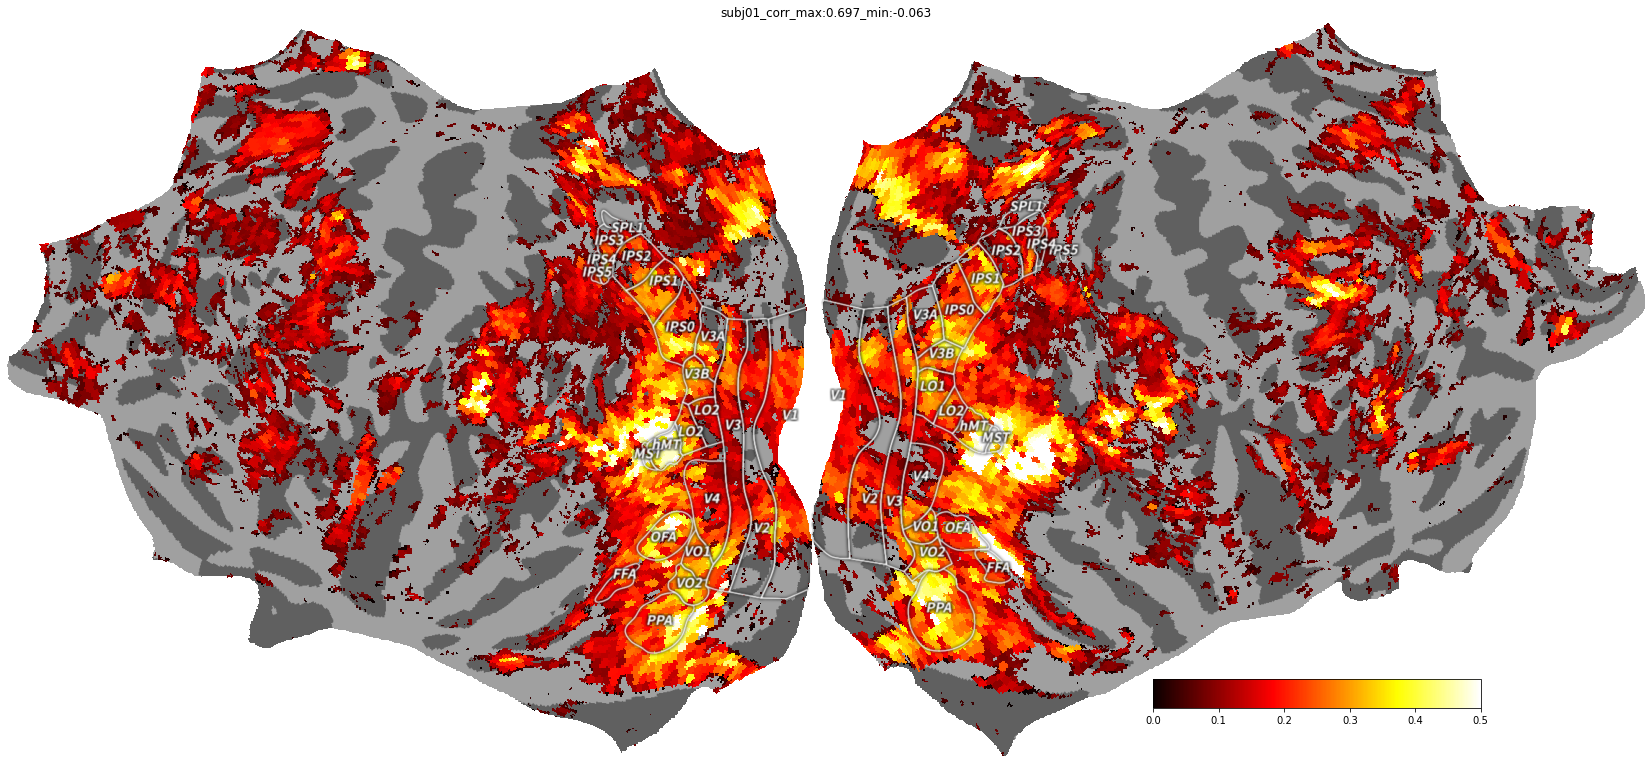

In [9]:
# 可视化
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

project_path = "/data/public/wbc/data_analysis/nsddata_voxel_analysis/things/ViLT/output/"

subj_root = project_path + subj
#需要用fsaverage7的mask
corr_p_data = np.load(os.path.join(subj_root,'%s_corr_%s.npy'%(method, "fsaverage")))
# corr_p_data = np.load("/data/public/wbc/data_analysis/nsddata_voxel_analysis/things/feature_extractor/bert/output/subj01/corr_fsaverage_full.npy")
    # 找到p=0.01的相关系数值
p_list = corr_p_data[:,1]
p_fdr = ssm.fdrcorrection(p_list, alpha=0.01)
corr_p_data_fdr = np.copy(corr_p_data)
corr_p_data_fdr[:,1] = p_fdr[1]
p001 = find_nearest(corr_p_data_fdr[:,1],0.001)
p_mask = np.where(corr_p_data_fdr[:,1]<0.001)
r_p001 = corr_p_data_fdr[corr_p_data_fdr[:,1]==p001][0][0]
r_p001 = format(r_p001, '.3f')


def upsample(fsaverage5_data, temp_path, sub, hemi):
    fs5_data = fsaverage5_data
    fs7_res = 163842
    temp_path = "subj0{}_hemi_{}".format(sub, hemi)
    pathlib.Path(temp_path).mkdir(parents=True,exist_ok=True)
    new_data = np.zeros((fs5_data.shape[0],fs7_res,1),dtype=np.float32)
    stat_map = fs5_data
    img = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(stat_map.astype("float32"))])
    nib.save(img, 'subj0{}_hemi_{}/temp5.func.gii'.format(sub,hemi))
    os.system("wb_command -metric-resample subj0{}_hemi_{}/temp5.func.gii {}.fsaverage5.sphere.surf.gii {}.fsaverage.sphere.surf.gii ADAP_BARY_AREA subj0{}_hemi_{}/temp.func.gii -largest -area-surfs {}_fsaverage5.white.surf.gii {}_fsaverage.white.surf.gii".format(sub, hemi, hemi, hemi, sub, hemi, hemi, hemi))
    data = surface.load_surf_data("subj0{}_hemi_{}/temp.func.gii".format(sub, hemi))
    new_data = data
    return new_data

temp_path = "subj0{}_hemi_{}".format(1, "lh")
lh_data = upsample(corr[:,0][:len(corr[:,0])//2],temp_path, 1, "lh")
shutil.rmtree(temp_path)
temp_path = "subj0{}_hemi_{}".format(1, "rh")
rh_data = upsample(corr[:,0][len(corr[:,0])//2:],temp_path, 1, "rh")
shutil.rmtree(temp_path)

data = np.concatenate([lh_data,rh_data], axis=0)
maxValue = format(data.max(), '.3f')
minValue = format(data.min(), '.3f')

surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(fsa, "fiducial")]
# vertex_data = cortex.Vertex(data, fsa, vmax=1, vmin=0)
data_p = np.array([0 for i in range(data.shape[0]) ]).astype("float32")
data_p[p_mask] = data[p_mask]
data_p[np.where(data_p==0)] = np.nan
vertex_data = cortex.Vertex(data_p, "fsaverage", vmax=0.5, vmin=0, with_colorbar=True, cmap="hot")
cortex.quickshow(vertex_data, with_curvature=True, with_colorbar=True, colorbar_location="right")

plt.title('%s_%s_max:%s_min:%s'%(subj,"corr",maxValue, minValue))
plt.show()